In [1]:
%%javascript
console.log("Teste");
require(['notebook/js/codecell'], function(codecell) {
  codecell.CodeCell.options_default.highlight_modes['text/x-rustsrc'] = {'reg':[/^%%prov/]} ;
  Jupyter.notebook.events.one('kernel_ready.Kernel', function(){
  Jupyter.notebook.get_cells().map(function(cell){
      if (cell.cell_type == 'code'){ cell.auto_highlight(); } }) ;
  });
});


<IPython.core.display.Javascript object>

In [2]:
from IPython.core.magic import Magics, magics_class, cell_magic
from IPython.core.magic_arguments import  magic_arguments, argument, parse_argstring
from IPython.display import Image

@magics_class
class ProvMagic(Magics):
    
    @cell_magic
    def prov(self, line, cell):
        path = line.split(" ", 1)[-1]
        result = self.shell.run_cell_magic("provn", f"-o {path} -e pdf svg provn dot -s paper4", cell)
        self.shell.system(f"inkscape -f {path}.svg -e {path}.png -d 300")
        return Image(f"{path}.png")
get_ipython().register_magics(ProvMagic)

In [3]:
%reload_ext extensible_provn.prov_magics
import extensible_provn.view.versioned_prov
BASE = "../generated/presentation"

# Versioned-PROV: A PROV extension to support mutable data entities

Authors:
- João Felipe Pimentel
- Paolo Missier
- Leonardo Murta
- Vanessa Braganholo

# PROV

- Entensible model
- Domain-agnostic
  - Operating Systems
  - Workflow Systems
  - Scripts
  - ...
 
![PROV key concepts overview. The figure shows an entity, an agent, and an activity](https://www.w3.org/TR/2013/NOTE-prov-primer-20130430/images/key-concepts.png)
Image from PROV Model Primer
https://www.w3.org/TR/2013/NOTE-prov-primer-20130430/
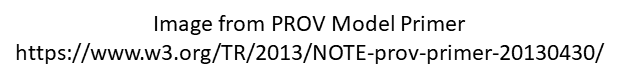

# PROV for Scripts

- Existing approaches describe coarse-grained provenance

```python
i = 534
j = 237
k = 789
min(i, j, k)
```

In [ ]:
%%prov $BASE/call
entity(i, [value="534", type="script:name", label="i"])
entity(j, [value="237", type="script:name", label="j"])
entity(k, [value="789", type="script:name", label="k"])

entity(result, [value="237", type="script:evaluation"])
activity(min, [type="script:call"])
wasDerivedFrom(result, j, min, g1, u1)
wasGeneratedBy(g1; result, min)
used(u1; min, j, [dot:dist="0"])
used(min, i)
used(min, k, [dot:dist="2"])

# Fine-Grained Provenance

- Assignment

```python
m = 10000
```

In [ ]:
%%prov $BASE/assign
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>
    
entity(10000, [value="10000", type="script:literal"])
entity(m, [value="10000", type="script:name", label="m"])

activity(assign1, [type="script:assign"])
wasDerivedFrom(m, 10000, assign1, -, u1, [dot:dist="1.5"])
wasGeneratedBy(g1; m, assign1, [dot:dist="0"])
used(u1; assign1, 10000, [dot:dist="1.5"])

# Challenges

- PROV entities are immutable
- Two main problems

# P1

When an assignment to a collection entity occurs, the new entity should have all the members of the original entity.

- N `hadMember` statements

```python
a = [2, 6, 0]

b = a
```

In [ ]:
%%prov $BASE/p1
newrank=true;
splines = "spline"

subgraph cluster_0 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "A";
    "g/a#1";
    "g/b#1"; "g/assign2"
    "g/a#1-attrs";
    "g/b#1-attrs"; "g/assign2-attrs"
    
}
subgraph cluster_1 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "B";
    "g/2"; "g/6";  "g/0"; 
}
##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>


entity(2, [value="2", type="script:literal", dot:hide2="true"])
entity(6, [value="6", type="script:literal", dot:hide2="true"])
entity(0, [value="0", type="script:literal", dot:hide2="true"])

entity(a#1, [value="[2, 6, 0]", type="script:name", label="a"])
entity(b#1, [value="[2, 6, 0]", type="script:name", label="b"])

hadMember(a#1, 2, [dot:hide2="true"])
hadMember(a#1, 6, [dot:hide2="true"])
hadMember(a#1, 0, [dot:hide2="true"])

hadMember(b#1, 2, [dot:specific="true"])
hadMember(b#1, 6, [dot:specific="true"])
hadMember(b#1, 0, [dot:specific="true"])

activity(assign2, [type="script:assign"])
wasDerivedFrom(b#1, a#1, assign2, u2, g2, [dot:dist="2"])
used(u2; assign2, a#1, -, [dot:dist="0"])
wasGeneratedBy(g2; b#1, assign2, -, [dot:dist="0"])
endDocument
##F##
{rank=same "g/a#1" "g/a#1-attrs"}
{rank=same "g/2" "g/6" "g/0"}
"g/0" -> "g/6" -> "g/2" [style=invis]


# P2-simplified

When an entity that represents a collection is changed, a new entity should be created, together with multiple new relationships.

- 1 `entity` + 2 `wasDerivedFrom` + N `hadMember` = 3 + N statements

```python
a = [2, 6, 0]

a[1] = 3
```

In [ ]:
%%prov $BASE/p2simple
newrank=true;
splines = "spline"

subgraph cluster_0 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "A";
    "g/a@1"; "g/1"; "g/3"
    "g/a#1"; "g/assign3"
    "g/a@1-attrs"; "g/1-attrs"; "g/3-attrs"
    "g/a#1-attrs"; "g/assign3-attrs"
    
}
subgraph cluster_1 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "B";
    "g/0"; "g/6"; "g/2";
}

subgraph cluster_2 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "24"
    label = "C";
    "g/a#2"; "g/a#2-attrs" 
}
##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>

entity(2, [value="2", type="script:literal", dot:hide2="true"])
entity(6, [value="6", type="script:literal", dot:hide2="true"])
entity(0, [value="0", type="script:literal", dot:hide2="true"])

entity(3, [value="3", type="script:literal"])
entity(1, [value="1", type="script:literal"])
entity(a#2, [value="[2, 3, 0]", type="script:name", label="a", dot:specific="true"])
entity(a#1, [value="[2, 6, 0]", type="script:name", label="a"])

entity(a@1, [value="3", type="script:access", label="a[1]"])
       
hadMember(a#1, 2, [dot:hide2="true"])
hadMember(a#1, 6, [dot:hide2="true"])
hadMember(a#1, 0, [dot:hide2="true"])

hadMember(a#2, 2, [dot:specific="true"])
hadMember(a#2, a@1, [dot:specific="true"])
hadMember(a#2, 0, [dot:specific="true"])

activity(assign3, [type="script:assign"])
wasDerivedFrom(a#2, a#1, assign3, g3, u3, [dot:specific="true"])
used(u3; assign3, a#1, -)
wasDerivedFrom(a#2, 3, assign3, g3, u4, [dot:specific="true"])
wasDerivedFrom(a@1, 3, assign3, g4, u4)
used(assign3, 1, -)
endDocument
##F##
{rank=same "g/2" "g/6" "g/0"}
{rank=same "g/a@1" "g/a#2"}
"g/0" -> "g/6" -> "g/2" [style=invis]
"g/1" -> "g/2" [style=invis]
"g/a#2" -> "g/6" [style=invis]


# P2

When more than one variable is assigned to the same collection, and one of the variables changes, all other variables should also change, as they refer to the same memory area.

- 3 + N statements **for each** reference

```python
a = [2, 6, 0]
b = a

a[1] = 3
```

In [ ]:
%%prov $BASE/p2
newrank=true;
splines = "spline"

subgraph cluster_0 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "36"
    label = "A";
    "g/a@1"; "g/1"; "g/3"
    "g/a#1"; "g/assign3"
    
    "g/a@1-attrs"; "g/1-attrs"; "g/3-attrs"
    "g/a#1-attrs"; "g/assign3-attrs"
    
    
}
subgraph cluster_1 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "36"
    label = "B";
    "g/2"; "g/6"; "g/0"; "g/b#1";
}

subgraph cluster_2 {
    labeljust="r"
    labelloc="b"
    color = "#333333"
    fontcolor = "#333333"
    fontsize = "36"
    label = "C";
    "g/a#2";
    "g/b#2"; "g/b#2-attrs" 
}

##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>


entity(2, [value="2", type="script:literal", dot:hide2="true"])
entity(6, [value="6", type="script:literal", dot:hide2="true"])
entity(0, [value="0", type="script:literal", dot:hide2="true"])
entity(a#1, [value="[2, 6, 0]", type="script:name", label="a"])
entity(b#1, [value="[2, 6, 0]", type="script:name", label="b", dot:hide2="true"])
entity(3, [value="3", type="script:literal"])
entity(1, [value="1", type="script:literal"])
entity(a#2, [value="[2, 3, 0]", type="script:name", label="a", dot:hide2="true"])
entity(b#2, [value="[2, 3, 0]", type="script:name", label="b", dot:specific="true"])

       
       
entity(a@1, [value="3", type="script:access", label="a[1]"])
       
hadMember(a#1, 2, [dot:hide2="true"])
hadMember(a#1, 6, [dot:hide2="true"])
hadMember(a#1, 0, [dot:hide2="true"])
          
hadMember(b#1, 2, [dot:hide2="true"])
hadMember(b#1, 6, [dot:hide2="true"])
hadMember(b#1, 0, [dot:hide2="true"])

hadMember(a#2, 2, [dot:hide2="true"])
hadMember(a#2, a@1, [dot:hide2="true"])
hadMember(a#2, 0, [dot:hide2="true"])

hadMember(b#2, 2, [dot:specific="true"])
hadMember(b#2, a@1, [dot:specific="true"])
hadMember(b#2, 0, [dot:specific="true"])

          
activity(assign3, [type="script:assign"])
wasDerivedFrom(a#2, a#1, assign3, g4, u4, [dot:hide2="true"])
wasDerivedFrom(a#2, 3, assign3, g4, u4, [dot:hide2="true", dot:dist="0.5", dot:angle="270.0"])
used(u4; assign3, a#1, -, [dot:dist="2", dot:angle="-30.0"])
wasGeneratedBy(g4; a#2, assign3, -, [dot:hide2="true", dot:dist="1", dot:angle="270.0"])
wasDerivedFrom(b#2, b#1, assign3, g6, u6, [dot:specific="true"])
wasDerivedFrom(b#2, 3, assign3, g6, u5, [dot:specific="true"])
wasDerivedFrom(a@1, 3, assign3, g5, u5)

used(assign3, 1, -)
endDocument
##F##
{rank=same "g/2" "g/6" "g/0"}
{rank=same "g/a@1" "g/a#2" "g/b#2"}
//{rank=same "g/a#1" "g/a#1-attrs"}
{rank=same "g/1" "g/3"}
"g/0" -> "g/6" -> "g/2" [style=invis]
"g/1" -> "g/2" [style=invis]
//"g/2" -> "g/3" [style=invis]
"g/a#2" -> "g/6" [style=invis]
//"g/b#2" -> "g/6" [style=invis]


# Challenges

- PROV entities are immutable
- Two main problems
  - P1: $O(N)$ new elements in collection assignments
  - P2: $\Omega(R\times N)$ new elements in collection changes
- N: number of elements
- R: number of variables referring to the same collection

# Goal

Reduce the storage overhead in collection assignments and changes to 𝑂(1)

# Versioned-PROV

- PROV extension
  - Checkpoints, Reference Sharing, Accesses
- An entity may represent multiple versions of a data object
  - Checkpoints identify these versions

In [ ]:
%%prov $BASE/versioned
ranksep=0.1; 

subgraph cluster_1 {
    color=white
    "g/modify" [shape=box color=white fixedsize=true width=1.5]
    "g/remove" [shape=box color=white fixedsize=true width=1.5]
    "g/insert" [shape=box color=white fixedsize=true width=1.5]

    edge [minlen=6]
##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>

entity(a)
activity(insert)
activity(remove)
activity(modify)
used(insert, a, [dot:dist="1", dot:angle="-60"])
used(remove, a)
used(modify, a)
endDocument
##F##
}

subgraph cluster_0 {
    color=white
    node [shape=box color=white fixedsize=true width=1.5]
    chk1 [label="checkpoint: 1" ]
    chk10 [label="checkpoint: 10"]
    chk4 [label="checkpoint: 4" ]
    chk1 -> "g/insert" [style=invis]
    chk10 -> "g/remove" [style=invis]
    chk4 -> "g/modify" [style=invis]
}

In [ ]:
%%prov $BASE/timeline
ranksep=0.05
color=white
"g/modify" [shape=box color=white fixedsize=true width=1.5]
"g/remove" [shape=box color=white fixedsize=true width=1.5]
"g/insert" [shape=box color=white fixedsize=true width=1.5]
edge [minlen=2]
##H##
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>

entity(a)
activity(insert)
activity(remove)
activity(modify)
endDocument
##F##

    color=white
    node [shape=box color=white fixedsize=true width=1.5]
    chk1 [label="checkpoint: 1" ]
    chk10 [label="checkpoint: 10"]
    chk4 [label="checkpoint: 4" ]
    "g/insert" -> chk1  [style=invis minlen=1]
    "g/remove" -> chk10 [style=invis minlen=1]
    "g/modify" -> chk4  [style=invis minlen=1]
    
    "g/a" -> "g/insert" -> "g/modify" -> "g/remove" [arrowhead=none]
    end [label="" shape=box color=white fixedsize=true width=1.5]
    "g/remove" -> end

    
{rank=same "g/a" "g/insert"  "g/modify"  "g/remove" end}

# PROV Constraint

- Unique-generation constraint:
  - A PROV entity can only be generated once
- Versioned-PROV follows PROV semantics
  - Mutability occurs only in collection entities
  - A Versioned-PROV collection may have different **members** at different moments

# Incremental Membership

Source
```python
a = [2,6,0]
a.append(4) # insert 
a[1] = 3    # modify
a.pop()     # remove
```

Modify operation
```Rust
hadMember(a, 3, [type="version:Put", version:key="1", version:checkpoint="4"])
```

DPI: 300
Background RRGGBBAA: ffffff00
Area 0:0:1121.33:352 exported to 3504 x 1100 pixels (300 dpi)
Bitmap saved as: ../generated/presentation/incremental.png


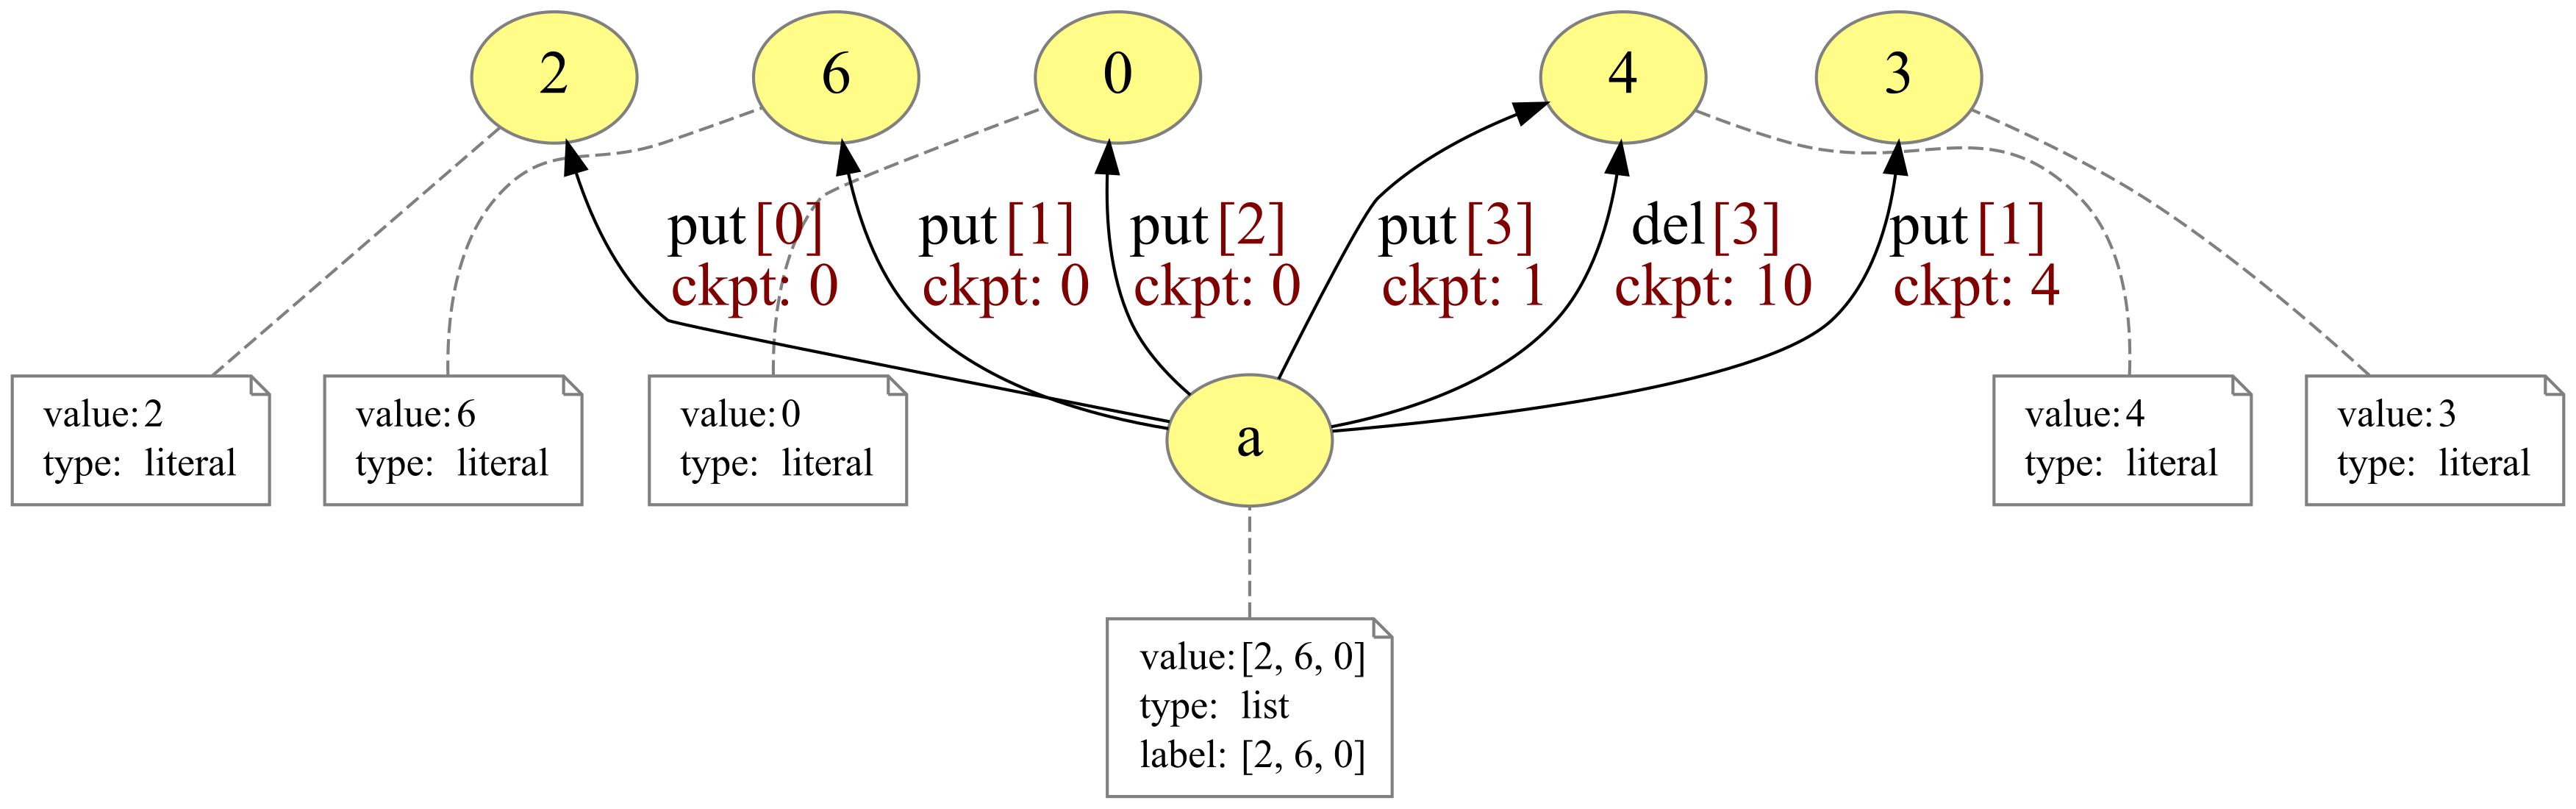

In [15]:
%%prov $BASE/incremental
document
default <g>
prefix script <https://dew-uff.github.io/versioned-prov/ns/script#>
prefix version <https://dew-uff.github.io/versioned-prov/ns#>


entity(6, [value="6", type="script:literal"])
entity(2, [value="2", type="script:literal"])
entity(0, [value="0", type="script:literal"])
entity(4, [value="4", type="script:literal"])
entity(3, [value="3", type="script:literal"])
entity(a, [value="[2, 6, 0]", type="script:list", label="[2, 6, 0]"])
hadMember(a, 2, [type="version:Put", version:key="0", version:checkpoint="0"])
hadMember(a, 6, [type="version:Put", version:key="1", version:checkpoint="0"])
hadMember(a, 0, [type="version:Put", version:key="2", version:checkpoint="0"])
hadMember(a, 4, [type="version:Put", version:key="3", version:checkpoint="1"])
hadMember(a, 3, [type="version:Put", version:key="1", version:checkpoint="4"])
hadMember(a, 4, [type="version:Del", version:key="3", version:checkpoint="10"])

endDocument
##F##
"g/2"->"g/6"->"g/0"->"g/4"->"g/3" [style=invis]
{rank=same "g/2" "g/6" "g/0" "g/3" "g/4" }